In [1]:
### import the packages needed 
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import numpy as np
import itertools

from scipy import linalg
import sklearn
from sklearn.datasets import make_blobs, make_circles, make_moons

import plotly_express as px

import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt 


import altair as alt
np.random.seed(31)
%matplotlib inline

In [2]:
### set the default figure size for marplotlib plot to be 10 inches in width and 6 inches in height
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
# load the data CSV file 

df=pd.read_csv('/rds/general/user/hg1222/home/Group5/matching/matched_data.csv', header=0, index_col=0)

In [4]:
df.shape

(14625, 30)

In [5]:
### drop out the columns that are not needed 
df.drop(['cancer'], axis =1, inplace=True)
df.drop(['X.1', 'X', 'eid'], axis =1, inplace=True)
df.drop(['case_status', 'case_lymph', 'case_leuk'], axis =1, inplace=True)

In [6]:
df.shape

(14625, 23)

In [7]:
### standardize the data,  scalling the features to have zero mean and unit variance

from sklearn.preprocessing import StandardScaler 

# Create a StandardScaler object 
scaler = StandardScaler()

# Fit the scaler to the data 
scaler.fit(df)

# Transform the data 
df_standardized = scaler.transform(df)

In [8]:
## df_standardized after scaling is an array, not a pandas DataFrame
## convert back to a dataframe 

df_standardized = pd.DataFrame(df_standardized, columns = df.columns)

In [9]:
df_standardized.shape

(14625, 23)

<AxesSubplot: >

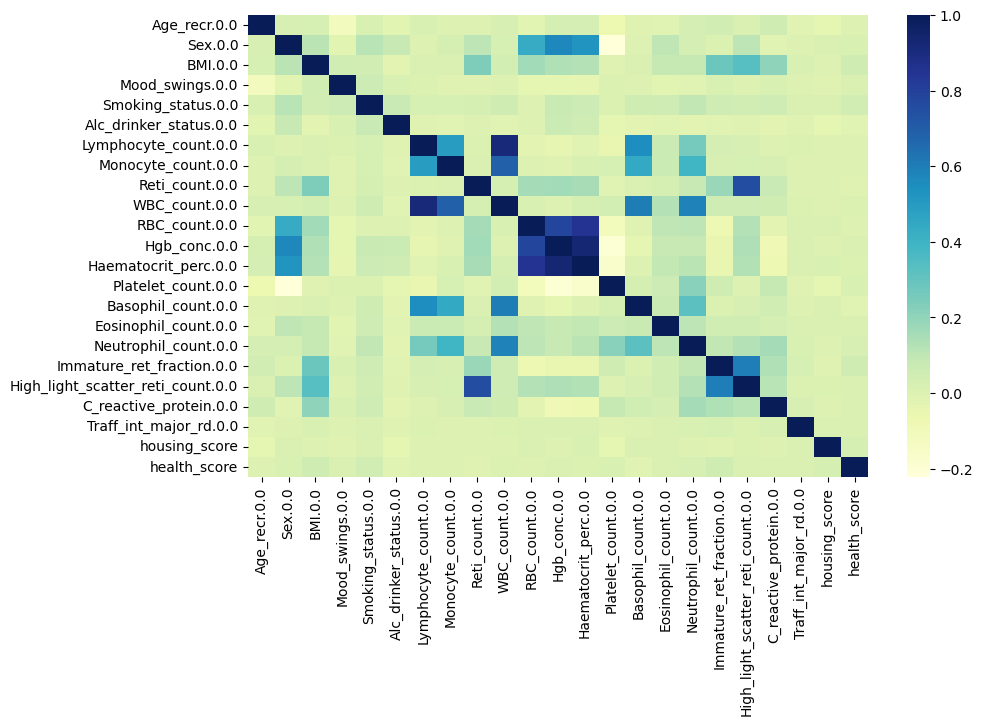

In [10]:
### check the correlation matrix to see if I need to use PCA or not 

import seaborn as sns

# Generate correlation matrix
corr_matrix = df_standardized.corr()

# Plot heatmap of correlation matrix
sns.heatmap(corr_matrix, cmap="YlGnBu")


Explained variance of each component: [1.48119761e-01 1.37550497e-01 9.55649467e-02 5.30439286e-02
 4.99201575e-02 4.83387410e-02 4.61921763e-02 4.33848849e-02
 4.33160357e-02 4.22413919e-02 4.11235774e-02 3.88631406e-02
 3.59254873e-02 3.36858286e-02 3.01800994e-02 2.70973067e-02
 2.48825012e-02 2.25325951e-02 2.15144688e-02 8.85511808e-03
 5.24095990e-03 2.42469594e-03 1.70041951e-06]


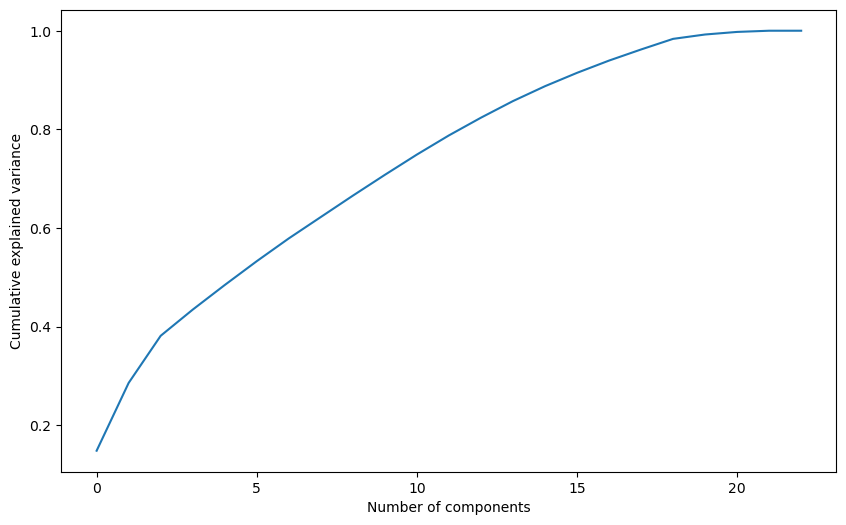

In [13]:
### there are multicollinearity, maybe do a PCA?

from sklearn.decomposition import PCA

# Create a PCA object with number of components equal to number of features
pca = PCA(n_components=df.shape[1])

# Fit PCA on standardized data
pca.fit(df_standardized)

# Get explained variance ratio of each component
explained_variance = pca.explained_variance_ratio_

# Print explained variance of each component
print("Explained variance of each component:", explained_variance)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


Each element of the array represents the proportion of the total variance in the original data that is explained by the corresponding principal component. For example, the first element of the array (1.48119761e-01) indicates that the first principal component explains about 14.8% of the total variance in the data, while the second element (1.37550497e-01) indicates that the second principal component explains about 13.8% of the total variance in the data, and so on.

In [14]:
# Calculate the explained variance ratios
variance_ratios = pca.explained_variance_ratio_

# Calculate the percent variance explained
percent_variance_exp = np.round(variance_ratios * 100, 2)

print("Percent variance explained:", percent_variance_exp)

Percent variance explained: [14.81 13.76  9.56  5.3   4.99  4.83  4.62  4.34  4.33  4.22  4.11  3.89
  3.59  3.37  3.02  2.71  2.49  2.25  2.15  0.89  0.52  0.24  0.  ]


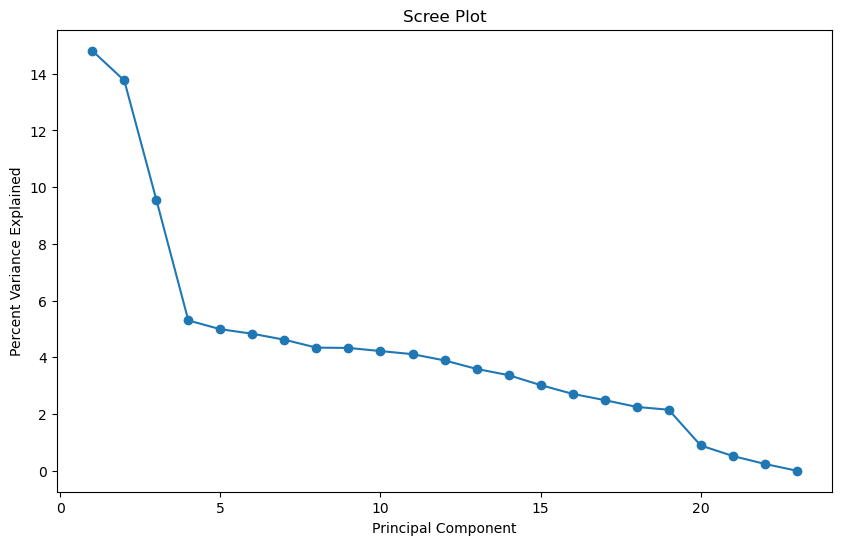

In [15]:
import matplotlib.pyplot as plt

# Create a scree plot
plt.plot(range(1, 24), percent_variance_exp, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Percent Variance Explained')
plt.title('Scree Plot')
plt.show()


In [16]:
print(df_standardized)

       Age_recr.0.0   Sex.0.0   BMI.0.0  Mood_swings.0.0  Smoking_status.0.0  \
0         -0.206118  0.920864  0.816489        -0.595990           -0.744352   
1          0.998828  0.920864 -0.691057        -0.595990            0.718840   
2         -0.657972 -1.085936  0.426256        -0.595990           -0.744352   
3          0.998828 -1.085936  1.213872        -0.595990            0.718840   
4          1.300064  0.920864 -0.276291        -0.595990            0.718840   
...             ...       ...       ...              ...                 ...   
14620      0.697591  0.920864  1.291068        -0.595990           -0.744352   
14621      0.697591  0.920864 -1.394210         1.260924           -0.744352   
14622      1.300064  0.920864 -1.060986        -0.595990            0.718840   
14623      1.300064 -1.085936 -1.172738        -0.595990           -0.744352   
14624      0.697591  0.920864  0.433008         1.260924            2.182032   

       Alc_drinker_status.0.0  Lymphocy

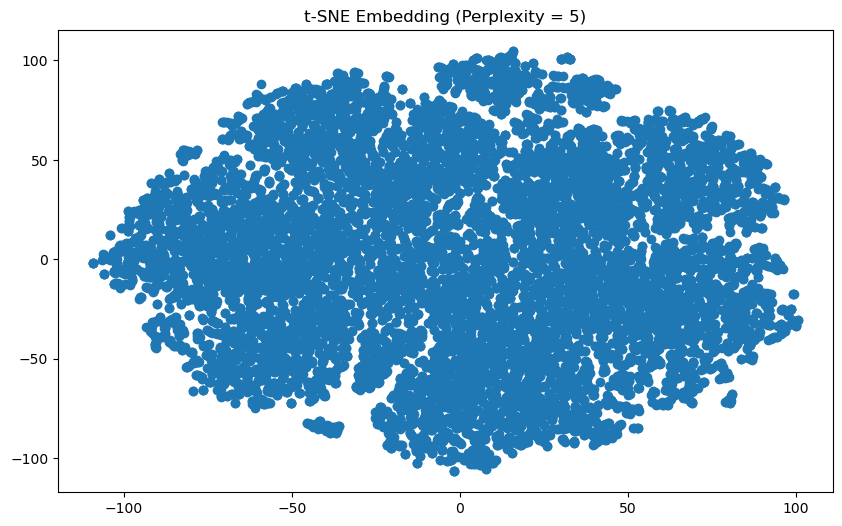

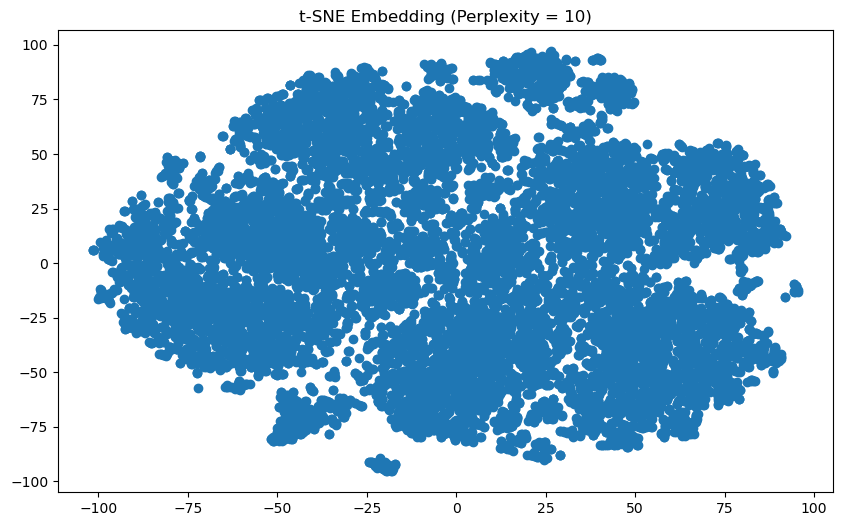

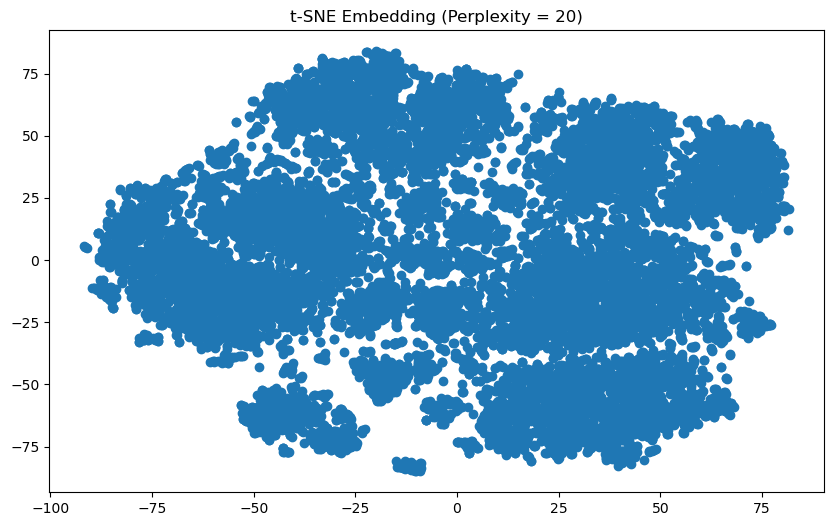

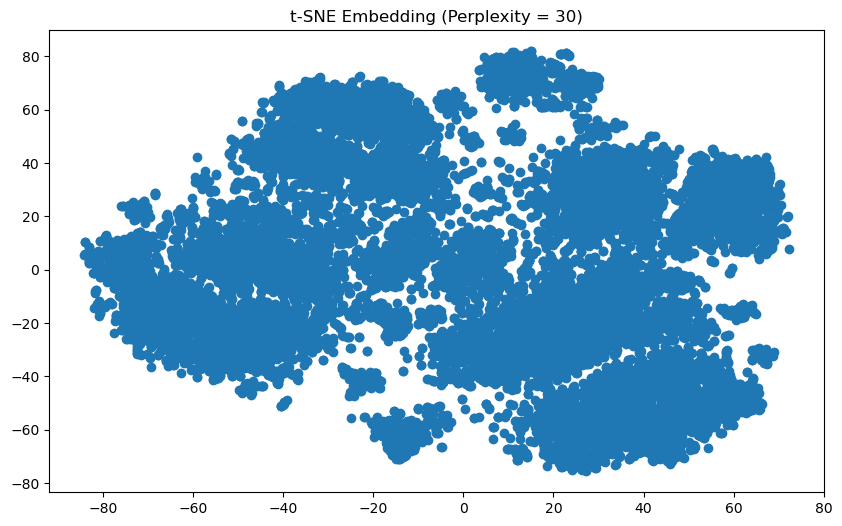

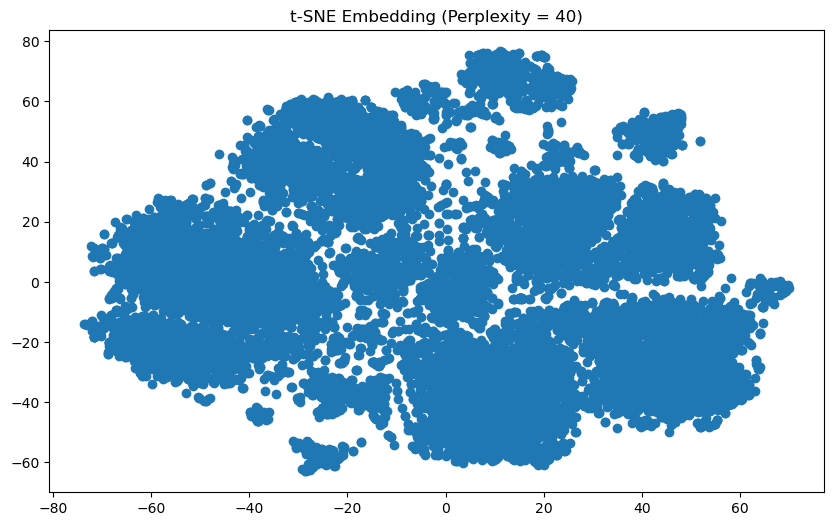

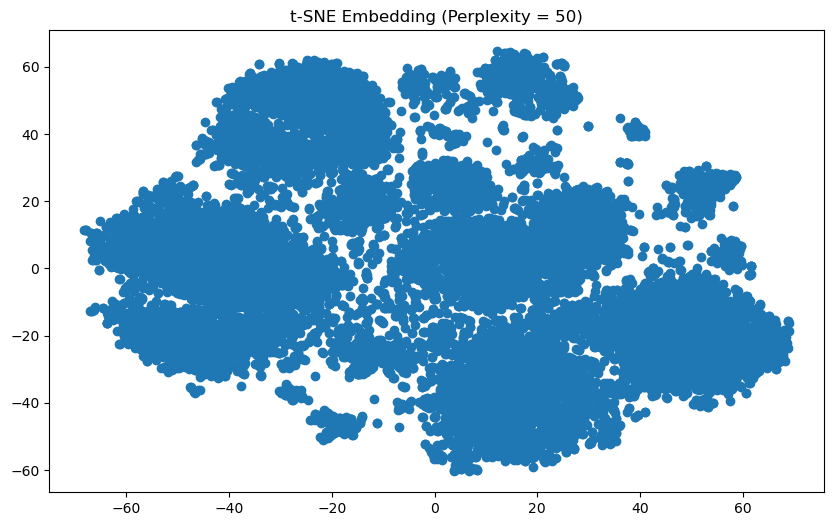

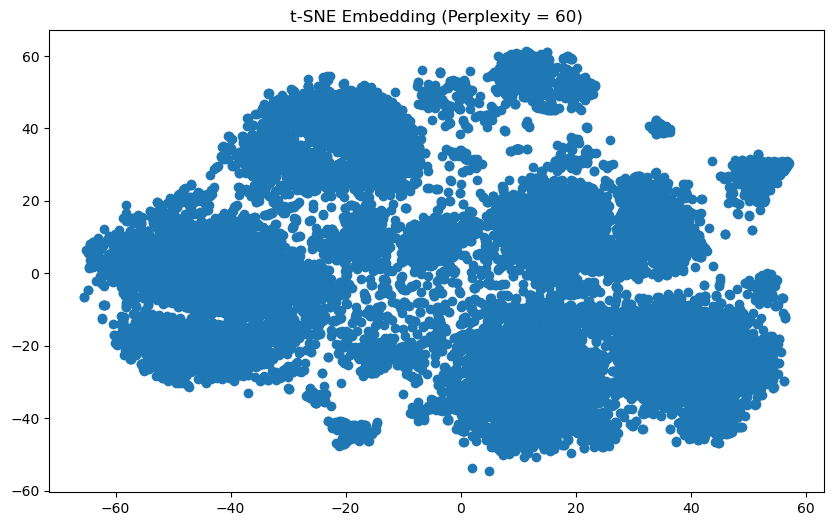

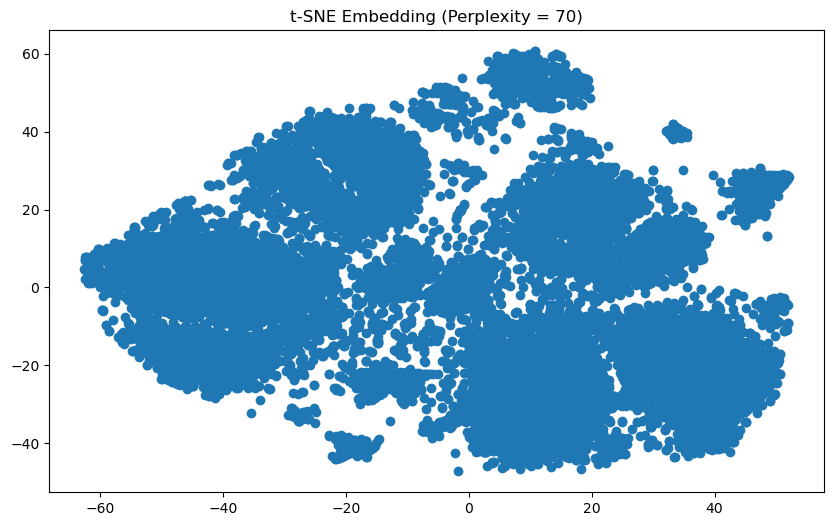

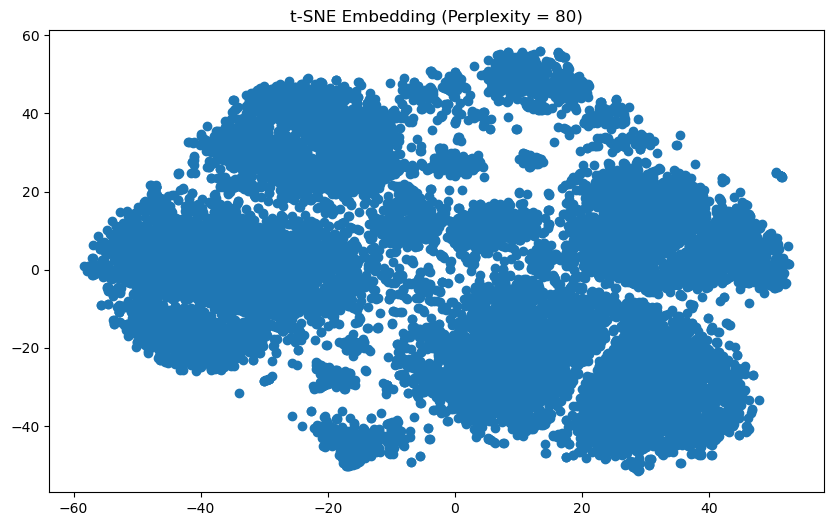

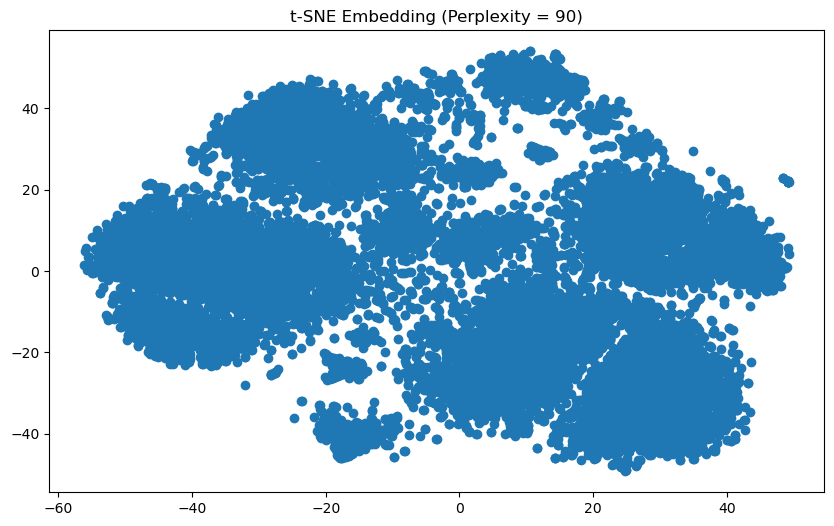

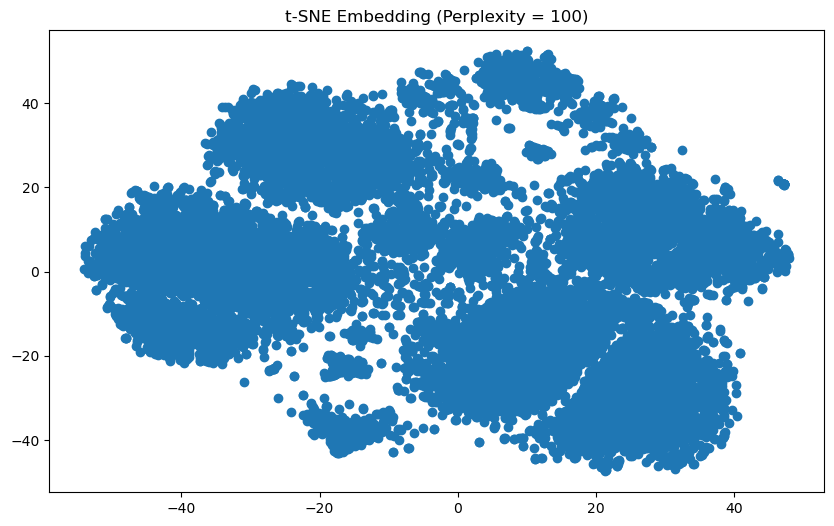

In [17]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# df_standardized is the high-dimensional data

# Define a grid of perplexicty values to test, 5, 20, 20, 30, 40, 50 
perplexities = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
 

# fit t-SNE model for each perplexity value using the training data
for perplexity in perplexities: 
    tsne = TSNE(n_components=2, perplexity=perplexity)
    X_tsne = tsne.fit_transform(df_standardized)

# Plot the results for each perplexity value
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    plt.title(f"t-SNE Embedding (Perplexity = {perplexity})")
    plt.show()

/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto

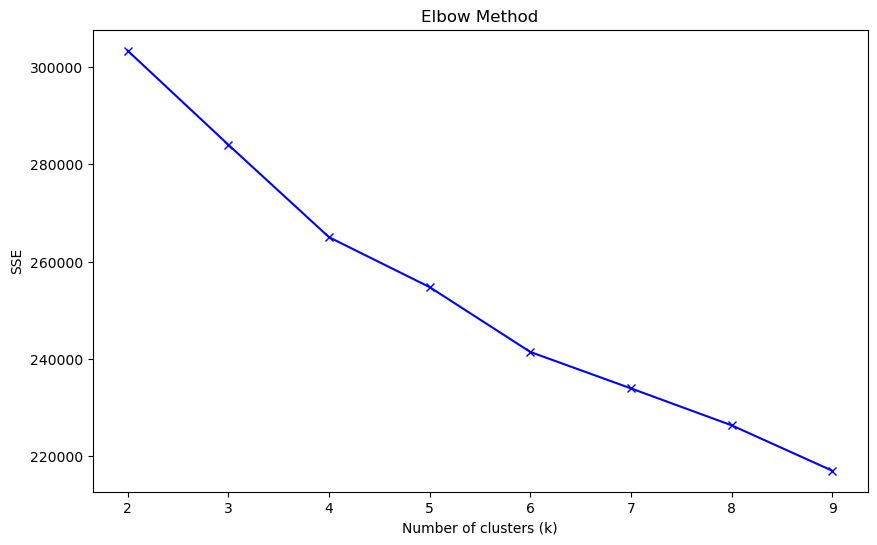

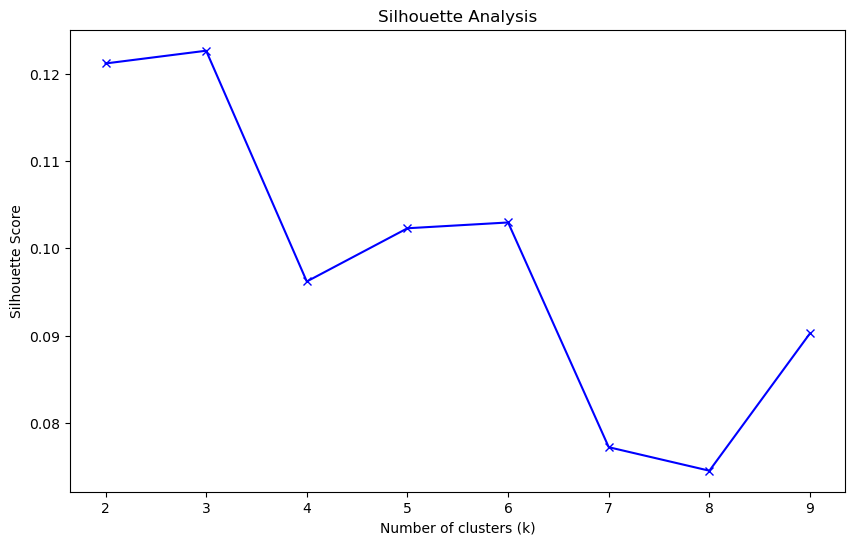

The optimal number of clusters is 3


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Define a range of number of clusters to test
k_range = range(2, 10)

# Initialize empty lists to store the SSE and silhouette scores
sse = []
silhouette_scores = []

# Fit KMeans for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_standardized, kmeans.labels_))

# Plot the elbow curve
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Plot the silhouette scores
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Find the optimal number of clusters based on the highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is {optimal_k}")

/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


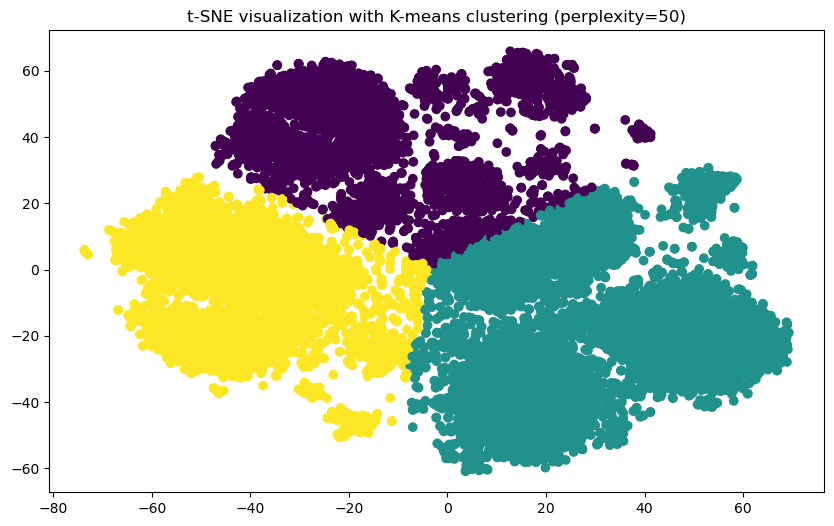

In [12]:
### try out k-means, mean shift, gaussian mixture and DBSCAN 
### the best perplexity value fot t-SNE(in this case, 30)

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# df_standardized is the high-dimensional data
perplexity = 50
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
X_tsne = tsne.fit_transform(df_standardized)

# Cluster the transformed data using K-means, use elbow method and silhouette to determine the optimal number of clusters 
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_tsne)

# Plot the transformed data with different colors for each cluster
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.title(f"t-SNE visualization with K-means clustering (perplexity={perplexity})")
plt.show()

In [13]:
from sklearn.mixture import GaussianMixture

# Define the number of clusters
n_clusters = 3

# Initialize the Gaussian Mixture model
gmm = GaussianMixture(n_components=n_clusters)

# Fit the model to the standardized dataframe
gmm.fit(df_standardized)

# Predict the cluster labels for each data point
cluster_labels = gmm.predict(df_standardized)



In [14]:
print(df_standardized)

       Age_recr.0.0   Sex.0.0   BMI.0.0  Mood_swings.0.0  Smoking_status.0.0  \
0         -0.206118  0.920864  0.816489        -0.595990           -0.744352   
1          0.998828  0.920864 -0.691057        -0.595990            0.718840   
2         -0.657972 -1.085936  0.426256        -0.595990           -0.744352   
3          0.998828 -1.085936  1.213872        -0.595990            0.718840   
4          1.300064  0.920864 -0.276291        -0.595990            0.718840   
...             ...       ...       ...              ...                 ...   
14620      0.697591  0.920864  1.291068        -0.595990           -0.744352   
14621      0.697591  0.920864 -1.394210         1.260924           -0.744352   
14622      1.300064  0.920864 -1.060986        -0.595990            0.718840   
14623      1.300064 -1.085936 -1.172738        -0.595990           -0.744352   
14624      0.697591  0.920864  0.433008         1.260924            2.182032   

       Alc_drinker_status.0.0  Lymphocy

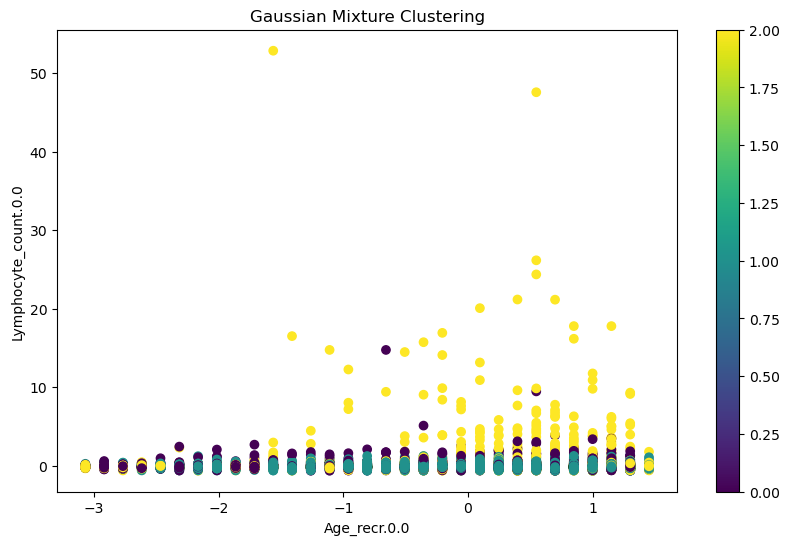

In [37]:
import matplotlib.pyplot as plt

# Extract the two columns of interest for plotting
x = df_standardized['Age_recr.0.0']
y = df_standardized['Lymphocyte_count.0.0']

# Plot the data points with colors according to their cluster labels
plt.scatter(x, y, c=cluster_labels, cmap='viridis')
plt.colorbar()

# Add plot title and axis labels
plt.title('Gaussian Mixture Clustering')
plt.xlabel('Age_recr.0.0')
plt.ylabel('Lymphocyte_count.0.0')

# Show the plot
plt.show()


In [44]:
print(df_standardized)

       Age_recr.0.0   Sex.0.0   BMI.0.0  Mood_swings.0.0  Smoking_status.0.0  \
0         -0.206118  0.920864  0.816489        -0.595990           -0.744352   
1          0.998828  0.920864 -0.691057        -0.595990            0.718840   
2         -0.657972 -1.085936  0.426256        -0.595990           -0.744352   
3          0.998828 -1.085936  1.213872        -0.595990            0.718840   
4          1.300064  0.920864 -0.276291        -0.595990            0.718840   
...             ...       ...       ...              ...                 ...   
14620      0.697591  0.920864  1.291068        -0.595990           -0.744352   
14621      0.697591  0.920864 -1.394210         1.260924           -0.744352   
14622      1.300064  0.920864 -1.060986        -0.595990            0.718840   
14623      1.300064 -1.085936 -1.172738        -0.595990           -0.744352   
14624      0.697591  0.920864  0.433008         1.260924            2.182032   

       Alc_drinker_status.0.0  Lymphocy

In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Evaluate K-Means clustering performance
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(df_standardized, kmeans.labels_)
kmeans_calinski = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Evaluate Gaussian Mixture clustering performance
gmm_bic = gmm.bic(df_standardized)
gmm_silhouette = silhouette_score(df_standardized, gmm.predict(df_standardized))
gmm_calinski = calinski_harabasz_score(df_standardized, gmm.predict(df_standardized))

print("K-Means - Inertia: {}, Silhouette Score: {}, Calinski-Harabasz Index: {}".format(kmeans_inertia, kmeans_silhouette, kmeans_calinski))
print("Gaussian Mixture - BIC: {}, Silhouette Score: {}, Calinski-Harabasz Index: {}".format(gmm_bic, gmm_silhouette, gmm_calinski))


K-Means - Inertia: 9761029.0, Silhouette Score: 0.0797656504341567, Calinski-Harabasz Index: 710.7237137761366
Gaussian Mixture - BIC: 531466.6151279701, Silhouette Score: 0.21750567947707974, Calinski-Harabasz Index: 773.7456397336307


In [ ]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score

#Perform Mean Shift clustering

ms = MeanShift()
ms.fit(df_standardized)

#Evaluate Mean Shift clustering performance

ms_silhouette = silhouette_score(df_standardized, ms.labels_)
ms_calinski = calinski_harabasz_score(df_standardized, ms.labels_)

print("Mean Shift - Silhouette Score: {}, Calinski-Harabasz Index: {}".format(ms_silhouette, ms_calinski))

It seems like Gaussian mixture is more suitable???

In [16]:
# Add the cluster labels as a new column
df_standardized['cluster_kmeans'] = kmeans.labels_

# Add the cluster labels to the dataframe
df_standardized['cluster_gaussian'] = cluster_labels

In [17]:
print(df_standardized)

       Age_recr.0.0   Sex.0.0   BMI.0.0  Mood_swings.0.0  Smoking_status.0.0  \
0         -0.206118  0.920864  0.816489        -0.595990           -0.744352   
1          0.998828  0.920864 -0.691057        -0.595990            0.718840   
2         -0.657972 -1.085936  0.426256        -0.595990           -0.744352   
3          0.998828 -1.085936  1.213872        -0.595990            0.718840   
4          1.300064  0.920864 -0.276291        -0.595990            0.718840   
...             ...       ...       ...              ...                 ...   
14620      0.697591  0.920864  1.291068        -0.595990           -0.744352   
14621      0.697591  0.920864 -1.394210         1.260924           -0.744352   
14622      1.300064  0.920864 -1.060986        -0.595990            0.718840   
14623      1.300064 -1.085936 -1.172738        -0.595990           -0.744352   
14624      0.697591  0.920864  0.433008         1.260924            2.182032   

       Alc_drinker_status.0.0  Lymphocy

In [20]:
# Calculate the mean values of features for each cluster
cluster_means = df_standardized.groupby('cluster_gaussian')['Age_recr.0.0','BMI.0.0','Mood_swings.0.0', 'Smoking_status.0.0', 'Alc_drinker_status.0.0', 'Lymphocyte_count.0.0', 'Monocyte_count.0.0', 'Reti_count.0.0', 'WBC_count.0.0', 'Basophil_count.0.0', 'Eosinophil_count.0.0', 'Neutrophil_count.0.0', 'Immature_ret_fraction.0.0', 'High_light_scatter_reti_count.0.0', 'C_reactive_protein.0.0', 'Traff_int_major_rd.0.0', 'housing_score', 'health_score' ].mean()

print(cluster_means)

                  Age_recr.0.0   BMI.0.0  Mood_swings.0.0  Smoking_status.0.0  \
cluster_gaussian                                                                
0                     0.053096  0.237636        -0.011450            0.075894   
1                    -0.009880 -0.044662         0.002206           -0.014361   
2                    -1.561682 -1.517691        -0.595990            0.718840   

                  Alc_drinker_status.0.0  Lymphocyte_count.0.0  \
cluster_gaussian                                                 
0                              -0.300387              0.418045   
1                               0.056775             -0.083078   
2                              -2.021516             52.825342   

                  Monocyte_count.0.0  Reti_count.0.0  WBC_count.0.0  \
cluster_gaussian                                                      
0                           0.108826        0.296597       0.434138   
1                          -0.029477       -0.0558

/var/tmp/pbs.7098330.pbs/ipykernel_77280/3398001504.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_means = df_standardized.groupby('cluster_gaussian')['Age_recr.0.0','BMI.0.0','Mood_swings.0.0', 'Smoking_status.0.0', 'Alc_drinker_status.0.0', 'Lymphocyte_count.0.0', 'Monocyte_count.0.0', 'Reti_count.0.0', 'WBC_count.0.0', 'Basophil_count.0.0', 'Eosinophil_count.0.0', 'Neutrophil_count.0.0', 'Immature_ret_fraction.0.0', 'High_light_scatter_reti_count.0.0', 'C_reactive_protein.0.0', 'Traff_int_major_rd.0.0', 'housing_score', 'health_score' ].mean()


[   0  606 2210 ...  282  531 2343]
int64
[   0    1    2 ... 3010 3011 3012]
[ True False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]


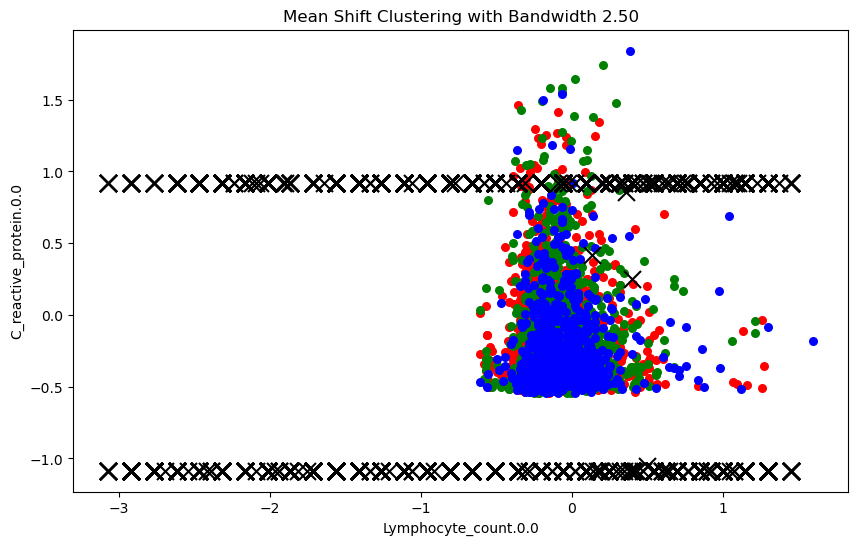

In [38]:
### mean shift 

import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Initialize bandwidth
bandwidth = 2.5

# Initialize MeanShift object with bandwidth parameter
ms = MeanShift(bandwidth=bandwidth)

# Fit the data
ms.fit(df_standardized)

# Get labels and cluster centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Print labels array for troubleshooting
print(labels)
print(labels.dtype)
print(np.unique(labels))

# Get number of clusters
n_clusters = 3

# Create a scatter plot with different colors for each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i in range(n_clusters):
    # Print indexing expression for troubleshooting
    print(labels == i)
    plt.scatter(df_standardized.loc[labels == i, 'Lymphocyte_count.0.0'], df_standardized.loc[labels == i, 'C_reactive_protein.0.0'], color=colors[i%8], s=30)

# Plot the cluster centers as black crosses
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=150, marker='x', color='k')

# Add axis labels and title
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('C_reactive_protein.0.0')
plt.title(f"Mean Shift Clustering with Bandwidth {bandwidth:.2f}")

# Show the plot
plt.show()


In [21]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score

#Perform Mean Shift clustering

ms = MeanShift()
ms.fit(df_standardized)

#Evaluate Mean Shift clustering performance

ms_silhouette = silhouette_score(df_standardized, ms.labels_)
ms_calinski = calinski_harabasz_score(df_standardized, ms.labels_)

print("Mean Shift - Silhouette Score: {}, Calinski-Harabasz Index: {}".format(ms_silhouette, ms_calinski))

Mean Shift - Silhouette Score: 0.17145280801279703, Calinski-Harabasz Index: 50.12083910266089


Number of clusters: 0


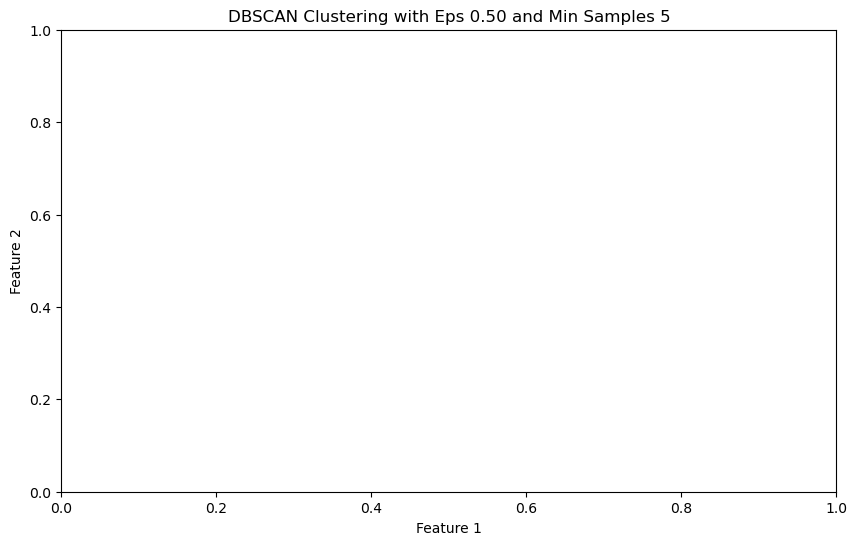

In [24]:
from sklearn.cluster import DBSCAN
import numpy as np

# Initialize DBSCAN object with eps and min_samples parameters
eps = 0.5
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the data
dbscan.fit(df_standardized)

# Get labels
labels = dbscan.labels_

# Get number of clusters (excluding noise points, labeled as -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {n_clusters}")

# Create a scatter plot with different colors for each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i in range(n_clusters):
    # Print indexing expression for troubleshooting
    print(labels == i)
    plt.scatter(df_standardized[labels == i, 0], df_standardized[labels == i, 1], color=colors[i%8], s=30)

# Add axis labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f"DBSCAN Clustering with Eps {eps:.2f} and Min Samples {min_samples}")

# Show the plot
plt.show()
